# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
# Ozmaden Deniz
# BSE 196

def H(y):
    """
    Calculate impurity criterion
    s
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """

    if (len(y) != 0):
        # if target is not empty
        diff = y - np.mean(y)
        numerator = np.power(diff, 2)
        # np.mean divides by n, which is denominator
        variance = np.mean(numerator)
        return variance
    else: 
        #if empty return 0
        return 0

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   

    # we find best split we need to first split by threshold
    # find indexes
    below = np.where(X[:, j] < t)
    above = np.where(X[:, j] >= t)

    # target objects by indexes of X
    R_left = y[below]
    R_right = y[above]

    # implement Q formula above
    # use H function implemented above to calculate variance
    left_side  = H(R_left) * len(R_left) / len(X)
    right_side = H(R_right) * len(R_right) / len(X)
    
    # return Q
    return left_side + right_side

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        # YOUR CODE HERE
        # initialize values that we need to return
        X_left, y_left, X_right, y_left = [0] * 4

        # we need to do full loop over X, so find rows & columns size
        row_size, column_size =  X.shape[0], X.shape[1]

        for r in range(row_size):
            for ind in range(column_size):
                
                # find current threshold value 
                threshold = X[r, ind]

                # calculate cost by above implemented function
                cost = Q(X, y, ind, threshold)

                # if current cost is better than best cost
                if (cost < best_cost):

                    # same logic as in cost function calculation
                    # find indexes below and above threshold
                    below = np.where(X[:, ind] < threshold)
                    above = np.where(X[:, ind] >= threshold)

                    # left values    
                    X_left, y_left =  X[below], y[below]

                    # right values    
                    X_right, y_right =  X[above], y[above]

                    # update every returned value
                    best_threshold = threshold
                    best_split_column = ind
                    best_cost = cost
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        # Check terminality conditions
        # added condition to check if everything is the same as 0 element
        # otherwise will be exception
        if (np.all(y[0] == y) or self.is_terminal(node, y)):
            node.is_terminal = True
            return
        
        # 2. Best split
        # find best values, assign column and threshold values to node
        node.column, node.threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        
        # inner function to construct left and right node
        def construct_node(lvl, y_side):
            side_node = Node()
            # calculate predictions of target values by child node
            side_node.prediction = np.mean(y_side)
            # add depth
            side_node.depth = lvl + 1
            return side_node

        # 3. adding child nodes
        node.left = construct_node(node.depth, y_left)
        node.right = construct_node(node.depth, y_right)

        # 4. calling function recursively to grow trees
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        if y is None:
            raise ValueError('Y should not be None')

        X, y = check_X_y(X, y, accept_sparse = False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, X):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """

        # objects than we need to predict
        vals = X[node.column]

        if node.is_terminal == False:
            # determining the needed node by threshold
            need_node = node.left if vals < node.threshold else node.right
            # recursively call predictions
            return self.get_prediction(need_node, X)
        else:
            # if terminal
            return node.prediction
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [8]:
from sklearn.datasets import load_boston

# load boston dataset
boston = load_boston()
X = boston.data # objects values
Y = boston.target # target values

In [9]:
from sklearn.model_selection import train_test_split

# split dataset by above mentioned params
# random_state = 0, because as far as I know it's what was recommended in previous notebooks?
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3, random_state = 0)

In [10]:
def threshold_split(X, ind, threshold):
    # return objects below & above threshold
    below = np.where(X[:, ind] < threshold)
    above = np.where(X[:, ind] >= threshold)
    return below, above

def plot_x(X, ind):
    return X[:, ind]

def get_params(tree):
    # get threshold value and column index 
    return tree.threshold, tree.column

In [11]:
def plot_training_points(dec_tree, X, y):
    # fir out model with training data
    dec_tree.fit(X, y)

    threshold, index  = get_params(dec_tree.tree_)

    below_vals, above_vals = threshold_split(X, index, threshold)

    # splitting the train dataset by threshold to left & right points
    x_left , x_right = X[below_vals], X[above_vals]
    y_left, y_right = y[below_vals], y[above_vals]

    # title of one plot
    plt.title("Training points and fitted model results")

    # plotting the threshold line to differentiate between points
    plt.axvline(threshold, color = 'black')

    # plot testing points below & above threshold
    plt.scatter(plot_x(x_left, index), y_left, color = 'lightblue', label = "training points")
    plt.scatter(plot_x(x_right, index), y_right, color = 'orange', label = "training points")
    # don't plot because apparently it should be on one plot?
    # weird, but ok

In [12]:
def plot_predictions(dec_tree, X, y):
    # get predictions with our model on test data
    pred = dec_tree.predict(X)

    threshold, index  = get_params(dec_tree.tree_)

    below_vals, above_vals = threshold_split(X, index, threshold)

    # split predictions by threshold
    pred_left, pred_right = pred[below_vals], pred[above_vals]
    
    # split testing point by threshold
    x_left, x_right =  X[below_vals], X[above_vals]
    y_left, y_right = y[below_vals], y[above_vals]

    # plot prediction points below & above threshold
    plt.scatter(plot_x(x_left, index), pred_left, color = 'darkviolet', label = "predictions")
    plt.scatter(plot_x(x_right, index), pred_right, color = 'crimson', label = "predictions")
    
    # plot testing points below & above threshold
    plt.scatter(plot_x(x_left, index), y_left, color = 'blue', label = "testing points")
    plt.scatter(plot_x(x_right, index), y_right, color = 'orangered', label = "testing points")
    
    plt.legend()
    # includes plot of training points
    plt.show()

In [13]:
# Decision tree of depth 1
dec_tree = MyDecisionTreeRegressor(1)

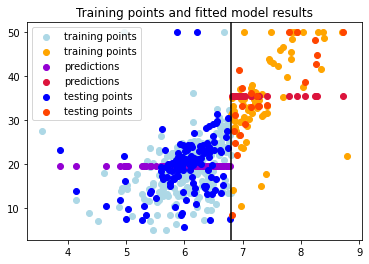

In [14]:
plot_training_points(dec_tree, X_train, y_train)
plot_predictions(dec_tree, X_test, y_test)

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [15]:
from sklearn.model_selection import GridSearchCV

dec_tree = MyDecisionTreeRegressor()

# default cv of GridSearchCV = 5 (5-fold cross validation)
# made max of params in param_grid = 10, because otherwise it takes a long time 
dec_tree_GSCV = GridSearchCV(estimator = dec_tree, param_grid = 
                            { "max_depth": np.arange(1, 10, 2), # 10 levels of depth, step = 2
                            'min_samples_split': np.arange(2, 10, 2) }, # 10 levels of split, step = 2
                            # rmse, same scoring as is in the seminar
                            scoring = 'neg_root_mean_squared_error',
                            verbose = 2)

In [16]:
dec_tree_GSCV.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.2s
[CV] max_depth=1, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................. max_depth=1, min_samples_split=2, total=   0.2s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.2s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.2s
[CV] max_depth=1, min_samples_split=2 ................................
[CV] ................. max_depth=1, min_samples_split=2, total=   0.2s
[CV] max_depth=1, min_samples_split=4 ................................
[CV] ................. max_depth=1, min_samples_split=4, total=   0.2s
[CV] max_depth=1, min_samples_split=4 ................................
[CV] ................. max_depth=1, min_samples_split=4, total=   0.2s
[CV] max_depth=1, min_samples_split=4 ................................
[CV] ................. max_depth=1, min_samples_split=4, total=   0.2s
[CV] max_depth=1, min_samples_split=4 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


GridSearchCV(estimator=MyDecisionTreeRegressor(),
             param_grid={'max_depth': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([2, 4, 6, 8])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [17]:
best_hyperparams = dec_tree_GSCV.best_params_
best_score = dec_tree_GSCV.best_score_ 

print("Best hyperparameters: {}".format(best_hyperparams))
print("Best achieved RMSE score: {}".format(best_score))

Best hyperparameters: {'max_depth': 7, 'min_samples_split': 4}
Best achieved RMSE score: -5.3642991608513535


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [18]:
def get_mean_bias(predictions, true):
    # we will use axis = 1 for predictions for some input
    pred_means = np.nanmean(predictions, axis = 1)
    biases = np.square(true - pred_means)
    mean = np.nanmean(biases, axis = 0)
    return mean

def get_mean_variance(predictions):
    # we will use axis = 1 for predictions for some input
    variances = np.nanvar(predictions, axis = 1)
    mean = np.nanmean(variances, axis = 0)
    return mean

def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    def array_of_NaNs(length):
        array = np.empty(length)
        array.fill(np.NaN)
        return array

    # input length of x and y 
    input_length = len(x)

    # we need to create a numpy array of overall predictions
    # we will update this during iterations
    predictions = array_of_NaNs(input_length)
    # fill with NaNs as of now
    # we basically have rows of inputs, later we will add columns of predictions

    # do n iterations
    for n in range(n_iter):

        # create an indexed sample of input_length
        sample = np.arange(input_length)

        # for bootstraping, randomly select from original sample with replacement
        rnd_gen = np.random.default_rng()
        bootstrapped_sample = rnd_gen.choice(sample, size = input_length, replace = True)
        
        # define OOB sample, which are values that appear in sample, but not in random
        out_of_bag_sample = np.setdiff1d(sample, bootstrapped_sample)

        # define training values
        input = x[bootstrapped_sample, :]
        target = y[bootstrapped_sample]

        # define testing values
        test = x[out_of_bag_sample, :]

        # train our estimator
        estimator.fit(input, target)

        # predict new values
        new_predictions = estimator.predict(test)

        # this will be a column of predictions based on OOB samples
        new_col = array_of_NaNs(input_length)
        
        # we'll need to fill our 1d array with this function
        np.put(new_col, out_of_bag_sample, new_predictions)
        
        # now add new column with new values to update overall predictions
        predictions = np.column_stack((predictions, new_col))

    # calculate mean bias and variance
    # go through the columns of predictions and ignore the NaNs
    mean_bias = get_mean_bias(predictions, y)
    mean_variance = get_mean_variance(predictions)

    return mean_bias, mean_variance

In [19]:
# Test
estimator = MyDecisionTreeRegressor(max_depth = 8, min_samples_split = 15)

get_bias_variance(estimator, X_train, y_train, 10)

<ipython-input-18-f7b17fd99a43>:3: RuntimeWarning: Mean of empty slice
  pred_means = np.nanmean(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(predictions, axis = 1)


(14.549441798216497, 7.163645160338785)

``` I don't think the runtime errors are right, everything should be logically correct... I could've supressed these warnings, but they're not as annoying so I just let them be. ```

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [20]:
N = 11 # depth levels

# to plot them later
biases = []
vars = []

for n in range(N):
    # create regressor for each depth
    # default samples split = 2
    dec_tree = MyDecisionTreeRegressor(n)
    
    # use above defined function to find means
    mean_bias, mean_variance = get_bias_variance(dec_tree, X_train, y_train, 10)

    # update for plotting
    biases.append(mean_bias)
    vars.append(mean_variance)

<ipython-input-18-f7b17fd99a43>:3: RuntimeWarning: Mean of empty slice
  pred_means = np.nanmean(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:3: RuntimeWarning: Mean of empty slice
  pred_means = np.nanmean(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:3: RuntimeWarning: Mean of empty slice
  pred_means = np.nanmean(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:3: RuntimeWarning: Mean of empty slice
  pred_means = np.nanmean(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(predict

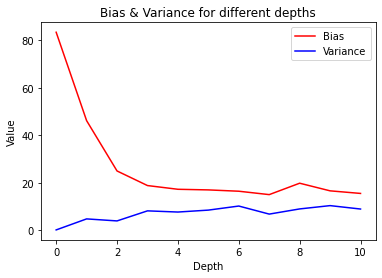

In [21]:
plt.title("Bias & Variance for different depths")
plt.xlabel("Depth")
plt.ylabel("Value")
plt.plot(np.arange(N), biases, color = "red", label = "Bias")
plt.plot(np.arange(N), vars, color = "blue", label = "Variance")
plt.legend()
plt.show()

``` As we go deeper and deeper in depth levels variance seems to rise, but slowly. My assumption would be is that if we increase depth levels it would slowly start to creep towards the upper side (overfitting). Bias values decrease significantly though. During training we start with a high bias (which means underfitting), but as we go deeper it decreases over time. The goal should be so that both variance and bias are in optimal conditions (low and balanced), which would be the perfect model (not underfitted, not overfitted). It seems as though our bias stabilized and keeps fluctuating at a certain point, with variance still relatively low. This would mean that our model is in a good spot and  would correspond to what was discussed on the lectures and seminars. ```

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in your experiments? 
 - Do your results align with the theory? Why?

In [22]:
from sklearn.ensemble import BaggingRegressor

# using the last depth from previous task
# default minimum split value = 2
dec_tree = MyDecisionTreeRegressor(N - 1)

bagging_reg = BaggingRegressor(dec_tree, random_state = 0)

In [23]:
# printing previous decision tree results
print("Bias of my last regressor without bagging: {}".format(biases[-1]))
print("Variance of my last regressor without bagging: {}".format(vars[-1]))

Bias of my last regressor without bagging: 15.525999870968464
Variance of my last regressor without bagging: 8.959885590031359


In [24]:
# use above implemented function for bagging regressor
bagging_bias, bagging_variance = get_bias_variance(bagging_reg, X_train, y_train, n_iter = 10) # n_iter the same as in the previous task

<ipython-input-18-f7b17fd99a43>:3: RuntimeWarning: Mean of empty slice
  pred_means = np.nanmean(predictions, axis = 1)
<ipython-input-18-f7b17fd99a43>:10: RuntimeWarning: Degrees of freedom <= 0 for slice.
  variances = np.nanvar(predictions, axis = 1)


In [25]:
# get results for bagging regressor
print("Bagging Regressor Bias: {}".format(bagging_bias))
print("Bagging Regressor Variance: {}".format(bagging_variance))

Bagging Regressor Bias: 11.114140642145232
Bagging Regressor Variance: 1.9095297166763439


``` 1. Ideally bagging should reduce variance without adversely affecting bias (increasing it). That would mean a better RMSE score.```

``` 2. We already saw how bias and variance change with regards to depth levels of decision trees in Task 7. In my experiments variance seems to remain low and bias seems to rapidly decrease and then stay stable and fluctuate around the same points. It seems like the model achieved some balance and is not overfitted nor underfitted. ```

``` 3. The results from the bagging regressor do allign with theory. Our variance significantly decreased, and even bias seems to have decreased as well. ```

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [26]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [28]:
# split dataset in train and test
# I use the same arguments as in the previous task
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 0)

In [29]:
def determine_NaN_column(data, threshold):
    mean_NaN = data.mean()
    to_drop_col = X.columns[threshold < mean_NaN]
    print(to_drop_col)

# determine which columns exceed the maximum NaN threshold
determine_NaN_column(X.isna(), 0.2)

Index(['T3', 'TBG'], dtype='object')


In [30]:
X.drop(['T3', 'TBG'], axis = 1).head(5)
# seems like TBG is completely NaN, and T3 just has a significant amount of it

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,1.30,t,t,125.0,t,1.14,t,109.0,f,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,4.10,t,t,102.0,f,NaN,f,NaN,f,other
2,46.0,M,f,f,f,f,f,f,f,f,...,0.98,f,t,109.0,t,0.91,t,120.0,f,other
3,70.0,F,t,f,f,f,f,f,f,f,...,0.16,t,t,175.0,f,NaN,f,NaN,f,other
4,70.0,F,f,f,f,f,f,f,f,f,...,0.72,t,t,61.0,t,0.87,t,70.0,f,SVI


In [31]:
# made just like in the example above double_transform
transform_categorical = make_pipeline(
                                    SimpleImputer(strategy = 'most_frequent'),
                                    OneHotEncoder(drop = 'if_binary')
                                    )

transform_numerical = SimpleImputer(strategy = 'median')

In [32]:
from sklearn.compose import make_column_selector

categorical_col = make_column_selector(dtype_include='object')
numerical_col = make_column_selector(dtype_include = 'float')

In [33]:
# define column_transformer

column_transformer = ColumnTransformer([('categorical', transform_categorical, categorical_col), ('numerical', transform_numerical, numerical_col)], remainder='passthrough')

In [34]:
# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [35]:
X_train

array([[  0.  ,   0.  ,   0.  , ...,  89.  ,   0.89, 100.  ],
       [  0.  ,   0.  ,   0.  , ..., 143.  ,   0.83, 173.  ],
       [  0.  ,   0.  ,   0.  , ..., 135.  ,   1.09, 124.  ],
       ...,
       [  0.  ,   1.  ,   0.  , ..., 121.  ,   0.95, 128.  ],
       [  0.  ,   0.  ,   0.  , ...,  82.  ,   0.66, 124.  ],
       [  0.  ,   0.  ,   0.  , ..., 123.  ,   1.23, 100.  ]])

In [36]:
X_test

array([[  0.  ,   0.  ,   0.  , ..., 110.  ,   0.96, 114.  ],
       [  1.  ,   0.  ,   0.  , ...,  83.  ,   0.83, 101.  ],
       [  1.  ,   0.  ,   0.  , ...,  88.  ,   0.87, 100.  ],
       ...,
       [  1.  ,   0.  ,   0.  , ...,  31.  ,   0.97, 107.  ],
       [  0.  ,   1.  ,   0.  , ..., 145.  ,   0.93, 155.  ],
       [  0.  ,   0.  ,   0.  , ..., 103.  ,   1.02, 101.  ]])

### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [37]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [38]:
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import cross_validate, StratifiedKFold

def test_model(model, X_train, y_train, X_test, y_test):
    # I chose recall score because our data is medical and I would argue
    # that it is crucial that we get this right, since the cost of false negative is high
    metric = "recall"

    # When doing this for the first time I used f1, which is a balance between precision and recall
    # but then I realized that recall is more important to us
    # since the False Negative is more costly than False Positive 
    #metric = "f1"

    # The description of task above says that I need to be mindful of "class balance"
    # when choosing cross-validation. I didn't quite get this, since cv = 5 as the
    # default seems reasonable to me. So as a compromise I decided to use
    # StratifiedKFold class as mentioned above to make 3-fold cross validation just 
    # like in the example of the documentation, but use the resulting test score 
    # only if it's better than 5-fold cross-validation
    five_fold_score = cross_validate(model, X_train, y_train, scoring = metric, return_estimator = True, return_train_score = True)
    three_fold_score =  cross_validate(model, X_train, y_train, cv = StratifiedKFold(n_splits = 3), scoring = metric, return_estimator = True, return_train_score = True)
    # I also return estimators from cv function to later predict y_test

    # getting mean test scores of each cv
    ff_mean_test_score = five_fold_score['test_score'].mean()
    tf_mean_test_score = three_fold_score['test_score'].mean()

    best_estimator = None
    if(ff_mean_test_score > tf_mean_test_score):
        # getting the last estimator of each cv 
        best_estimator = five_fold_score['estimator'][-1]
        # to determine underfitting & overfitting
        print("Train score: {}".format(five_fold_score['train_score'].mean()))
    else:
        best_estimator =  three_fold_score['estimator'][-1]
        print("Train score: {}".format(three_fold_score['train_score'].mean()))

    predictions = best_estimator.predict(X_test)
    #score_on_predictions = f1_score(y_test, predictions)
    score_on_predictions = recall_score(y_test, predictions)
    
    return score_on_predictions


In [39]:
print("Testing Gradient Boosting!")
# changed n_estimators to combat overfitting
gradient_boosting_score = test_model(GradientBoostingClassifier(random_state = 0, n_estimators = 10), X_train, y_train, X_test, y_test)
print("Gradient Boosting Classifier Test Score: {}".format(gradient_boosting_score))

Testing Gradient Boosting!
Train score: 0.7711775504851823
Gradient Boosting Classifier Test Score: 0.7662337662337663


In [40]:
print("Testing Forest Classifier!")
random_forest_score = test_model(RandomForestClassifier(n_estimators = 1, random_state = 0), X_train, y_train, X_test, y_test)
print("Random Forest Classifier Test Score: {}".format(random_forest_score))

Testing Forest Classifier!
Train score: 0.8393128769997377
Random Forest Classifier Test Score: 0.7792207792207793


In [41]:
print("Testing Decision Tree!")
decision_tree_score = test_model(DecisionTreeClassifier(max_depth = 3, random_state = 0),X_train, y_train, X_test, y_test)
print("Decision Tree Classifier Test Score: {}".format(decision_tree_score))

Testing Decision Tree!
Train score: 0.8536074624024367
Decision Tree Classifier Test Score: 0.7532467532467533


In [42]:
print("Testing SVC!")
svc_score = test_model(SVC(kernel = 'linear', random_state = 0), X_train, y_train, X_test, y_test)
print("Support Vector Classifier Test Score: {}".format(svc_score))

Testing SVC!
Train score: 0.7046766926835458
Support Vector Classifier Test Score: 0.6363636363636364


In [43]:
print("Testing Logistic Regression!")
logistic_regression_score = test_model(LogisticRegression(max_iter = 1000, random_state = 0), X_train, y_train, X_test, y_test)
print("Logistic Regression Test Score: {}".format(logistic_regression_score))

Testing Logistic Regression!
Train score: 0.6233936532913716
Logistic Regression Test Score: 0.5324675324675324


``` 1. Recall chosen as a metric since we have medical data and need to optimize for False Negatives. ```

``` 2. Random Forest Classifier seems to give the best performance with random_state = 0 (as far as I noticed sometimes it's also Gradient Boosting Classifier, when random_state is 42 they become equal and in other cases it may even become better). But when I started collecting train_scores I understood that these models were really overfitting (train scores near 1). So I started tinkering around and found that default n_estimators were largely responsible for this. I changed them and I think this stopped massive overfitting. In conclusion, I think both Gradient Boosting and Random Forest work well, but we need to be wary of overfitting.```

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [44]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [45]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
               
new_classifier = XGBClassifier()

hyperparams = {
 'max_depth': np.arange(0, 10, 2),
 'n_estimators': np.arange(0, 10, 2),
 'learning_rate': [0, 0.25, 0.5, 0.75, 1]
}

model = GridSearchCV(new_classifier, hyperparams, scoring = 'recall')

In [46]:
model.fit(X_train, y_train)

[23:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\Denis\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[23:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_re

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
            

In [47]:
# Same code as in Task 5

best_hyperparams = model.best_params_
best_score = model.best_score_ 

print("Best hyperparameters: {}".format(best_hyperparams))
print("Best achieved Recall score: {}".format(best_score))

Best hyperparameters: {'learning_rate': 0.75, 'max_depth': 6, 'n_estimators': 2}
Best achieved Recall score: 0.8643010752688172


```Recall score of XGBoost Classifier seems to be better than original Gradient Boosting Classifier and Random Forest Classifier from previous tasks.```

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [48]:
# YOUR CODE HERE

# too hard...

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

In [49]:
# XGBoost Classifier
print("Best achieved score: {}".format(best_score))

Best achieved score: 0.8643010752688172
